# Torchaudio FSC22 Dataset Example

**Notebook Overview:**
Basic examples of audio analysis and processing of the Forest Sound Classification 2022 (FSC22) Dataset. The goal is to make this as easy for others as possible, especially those more familiar with Matlab.  

**Dataset Description:** 
The dataset contains several examples of sounds from forests, along with classification of sound by category (e.g., environment/nature or human) and type (e.g., wind or talking) as shown in the following picture. Sound files are single- or duo-channel and sampled at 44.1kHz.  The Dataset contains 27 classes, each containing 75 audios related to the given class name.


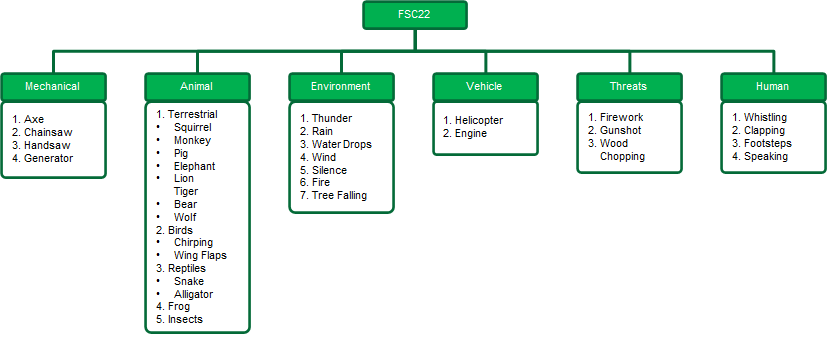

Dataset can be downlaoded from Kaggle: https://www.kaggle.com/datasets/irmiot22/fsc22-dataset



<a id='table_of_contents'></a>
# Table of contents 

1.0 [Audio Input](#input_sec)<br>
2.0 [Audio Analysis](#analysis_sec)<br>
3.0 [Downsampled](#resample_sec)<br>
4.0 [Mel-spectrograms](#mel_spec)<br>


# Misc. Imports

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.0.1
2.0.2


In [2]:
import io
import os
import tarfile
import tempfile

import matplotlib.pyplot as plt
import requests
from IPython.display import Audio
from torchaudio.utils import download_asset


In [3]:
#import my audio utilities plotting functions

from src_tools.audio_utilities import play_audio,plot_waveform,plot_specgram #basic audio and spectrogram tools
from src_tools.audio_utilities import plot_mel_specgram, plot_mel_specgram_vs_time, plot_mel_specgram_hz_vs_time #mel spectrogram tools
from src_tools.audio_utilities import plot_specgram_experimental #for showing 1 channel instead of both duo channels


<a id='input_sec'></a>

# 1.0 Audio Input

[back to table of contents](#table_of_contents)

## 1.1 Audio Data Path

In [4]:
SAMPLE_WAV = "data/FSC22/waveforms/27_12766.wav" #great squirrel chirp then squawks
#SAMPLE_WAV = "data/FSC22/waveforms/22_12266.wav" #great frog croaks & song


## 1.2 Query Metadata

In [5]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=240000, num_channels=2, bits_per_sample=16, encoding=PCM_S)


## 1.3 Load Audio Data


In [6]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

<a id='analysis_sec'></a>

# 2.0 Audio Analysis

[back to table of contents](#table_of_contents)

Basic analysis includes
- playing sound file
- plotting amplitude vs time of audio waveform
- plotting frequency vs time spectrogram of audio waveform (i.e. a short-time fourier transform with sliding window)

## 2.1 Play Audio File

In [7]:
play_audio(waveform, sample_rate) #wrapper that handles single-channel or duo-channel

## 2.2 Plot Time-Amplitude of Audio Data

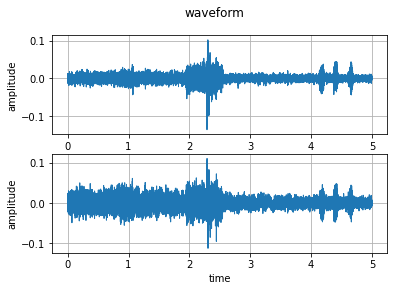

In [8]:
plot_waveform(waveform, sample_rate,title='waveform',xlabel='time',ylabel='amplitude')
#plot_waveform(waveform, sample_rate)


## 2.3 Plot Time-Frequency Spectrogram

plot_specgram_experimental(waveform, sample_rate=sample_rate, title='Spectrogram')#default: n_fft=1024, hop_length=512)
plot_specgram_experimental(waveform, sample_rate=sample_rate, title='Spectrogram 2',n_fft=2*2048, hop_length=1024)#worse time resolution, better time resolution


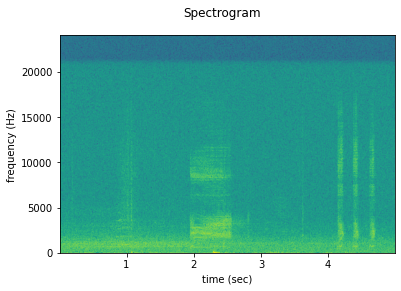

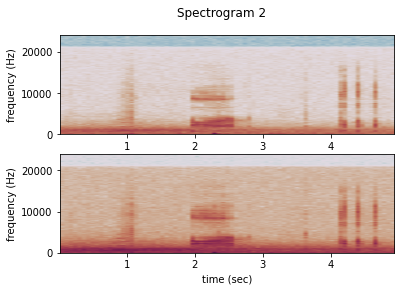

In [9]:
#show 1 channel
plot_specgram(waveform, sample_rate=sample_rate, title='Spectrogram',max_channels_show=1)#default: n_fft=1024, hop_length=512)

#show at most 2 channels at worse time but better frequency resolution
#also show with a different colormap (I recommend twilight_shifted or magma)
plot_specgram(waveform, sample_rate=sample_rate, title='Spectrogram 2',n_fft=2*2048, hop_length=1024,
              max_channels_show=2,cmap='twilight_shifted')#worse time resolution, better frequency resolution


<a id='resample_sec'></a>

# 3.0 Downsample to 16kHz (8kHz Nyquist)

[back to table of contents](#table_of_contents)

Downsample an audio waveform from one frequency to a lower one. We (usually) need to lowpass filter here to 
avoid aliasing. Default is to use Hann window filter (sinc_interp_hann) 

In [10]:
import torchaudio.transforms as T
import torchaudio.functional as F

### Waveform and (re)sample rates

In [11]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

resample_rate = 16000

#other interesting sampling rates
#resample_rate = 24000
#resample_rate = 4000
#resample_rate = 1000
#resample_rate = 500


print(f"sample_rate: {sample_rate}, resample_rate: {resample_rate}")

sample_rate: 48000, resample_rate: 16000


### Filter and Downsample

<br>

<ins>Parameters:</ins>
- **Lowpass filter width**: 
   Larger lowpass_filter_width --> sharper, more precise filter, but more computationally expensive.
- **Rolloff**:
   Lower rolloff value --> more attenuation (& thus reduced aliasing) near Nyquist. This will also reduce higher frequencies we may want to keep so beware.
- **Window filter function**:
   - default is Hann, which is a weighted cosine function. 
   - Kaiser is better. This is a near optimal window function that contains an additional ``beta`` parameter that allows for the design of the smoothness of the filter and width of impulse. This can be controlled using the ``resampling_method`` parameter.
   - Blackman or Parks-McClellan is more precise but can be overkill (to do)
   
   

In [12]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=12, 
                                rolloff=0.90, resampling_method="sinc_interp_kaiser")



### Check Results

In [13]:
#check audio -- downsampled version should have less higher frequency content
print("original waveform channels:")
play_audio(waveform, sample_rate)

print("resampled waveform channels:")
play_audio(resampled_waveform, resample_rate)#should have less high freq content than previous, & sound like below


original waveform channels:


resampled waveform channels:


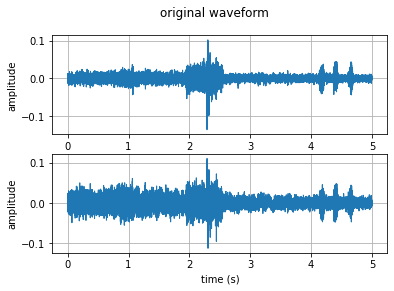

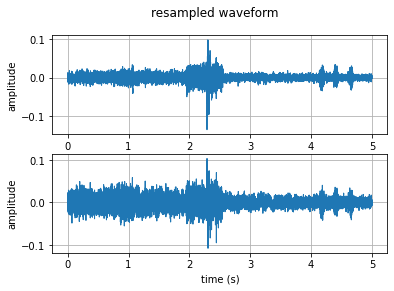

In [14]:
# check waveforms -- may look similar (just less points that can't easily be seen) or may look slightly smoother
plot_waveform(waveform, sample_rate,title='original waveform',xlabel='time (s)',ylabel='amplitude')
plot_waveform(resampled_waveform, resample_rate,title='resampled waveform',xlabel='time (s)',ylabel='amplitude')



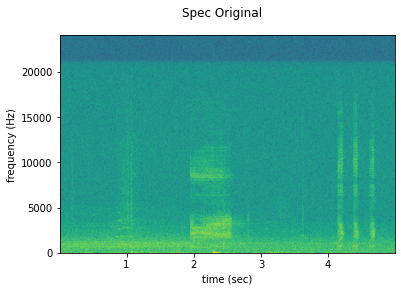

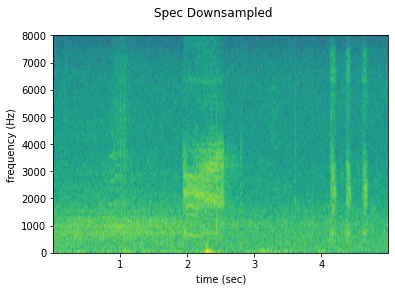

sample_rate: 48000, resample_rate: 16000


In [15]:
# check spectrograms -- everything below original Nyquist frequencey * 0.5( = 4kHz) should be similar 
# if aliasing is present, it won't look the same
#show only 1 channel here



plot_specgram(waveform, sample_rate, title='Spec Original',max_channels_show=1)

NS=1 #num scale factor to fiddle with, for convenience
plot_specgram(resampled_waveform, resample_rate, title='Spec Downsampled ', 
              n_fft=256*NS, hop_length=128*NS,max_channels_show=1)


print(f"sample_rate: {sample_rate}, resample_rate: {resample_rate}")

<a id='mel_spec'></a>

# 4.0 Mel-spectrograms

[back to table of contents](#table_of_contents)

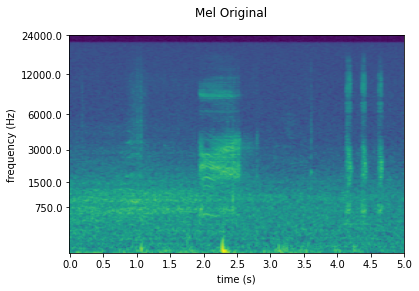

In [16]:
#plot mel spectrogram, mel filter center-frequency (in Hz) vs time (in seconds)
NS=32 #num scale factor to fiddle with, for convenience
plot_mel_specgram_hz_vs_time(waveform, sample_rate=sample_rate,title='Mel Original',
                            n_mels=NS*8, n_fft=NS*128, hop_length=NS*32)



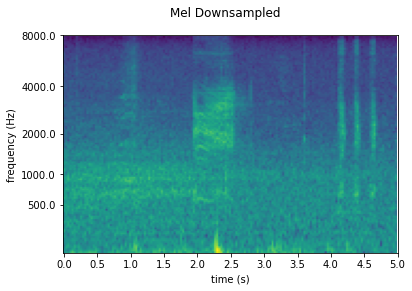

In [17]:
NS=16 #num scale factor to fiddle with, for convenience
plot_mel_specgram_hz_vs_time(resampled_waveform, sample_rate=resample_rate, title='Mel Downsampled',
                             n_mels=NS*8, n_fft=NS*64, hop_length=NS*32)
